In [1]:
# Librairies Standard
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import decomposition
from sklearn import preprocessing
from functions import *

import plotly.express as px
import plotly.graph_objects as go



In [2]:
# choix du nombre de composantes à calculer
n_comp = 8

# import de l'échantillon
df_total = pd.read_csv("./data/timesData.csv")
nb_ligne = 60                          # nombre de lignes affichées


In [3]:
#####################################################
################# Pre treatment #####################
#####################################################

df = df_total[df_total.year == 2016].iloc[:nb_ligne,:]
df = df.dropna()

df.world_rank = [each.replace('=','') for each in df.world_rank]
df.world_rank = pd.to_numeric(df.world_rank, errors='coerce')

df.income = pd.to_numeric(df.income, errors='coerce')

df.international = pd.to_numeric(df.international, errors='coerce')

df.total_score = pd.to_numeric(df.total_score, errors='coerce')

df.num_students  = [str(each).replace(',','') for each in df.num_students]

df.international_students = [each.replace('%','') for each in df.international_students]

df.female_male_ratio = [str(each).split() for each in df.female_male_ratio]
df.female_male_ratio = [round((float(each[0]) / float(each[2])),2)*100 for each in df.female_male_ratio] 
df.female_male_ratio = pd.to_numeric(df.female_male_ratio, errors='coerce')

In [4]:
# selection des colonnes à prendre en compte dans l'ACP
colonnes = ['total_score', 'research', 'teaching', 'citations', 'international', 'income', 
            'student_staff_ratio', 'num_students', 'international_students', 'female_male_ratio']
data_pca = df[colonnes]
data_pca.head()

,total_score,research,teaching,citations,international,income,student_staff_ratio,num_students,international_students,female_male_ratio
1803,95.2,97.6,95.6,99.8,64.0,97.8,6.9,2243,27,49.0
1804,94.2,98.9,86.5,98.8,94.4,73.1,11.6,19919,34,85.0
1805,93.9,96.2,92.5,99.9,76.3,63.3,7.8,15596,22,72.0
1806,92.8,96.7,88.2,97.0,91.5,55.0,11.8,18812,34,85.0
1807,92.0,88.6,89.4,99.7,84.0,95.4,9.0,11074,33,59.0


In [5]:
# préparation des données pour l'ACP
X = data_pca.values
names = df['world_rank'] # ou data.index pour avoir les intitulés
features = colonnes

In [6]:
# Centrage et Réduction
X_scaled = preprocessing.StandardScaler().fit_transform(X)

In [17]:
# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

PCA(n_components=8)

In [18]:
# Eboulis des valeurs propres : plot avec plotly

scree = pca.explained_variance_ratio_*100
fig2_1 = go.Figure()
fig2_1.add_trace(go.Scatter(x = np.arange(len(scree))+1, 
                            y = scree.cumsum(), 
                            mode = 'lines+markers',
                            name = 'Inertie cumulée',
                            hovertemplate = "<b>Pourcentage :</b> %{y} %<br>"
                            + "<extra></extra>"))
              
fig2_1.add_trace(go.Bar(x = np.arange(len(scree))+1, 
                        y = scree,
                        name = 'Inertie par composante',
                        hovertemplate = "<b>Composante :</b> %{x}<br>" 
                            + "<b>Pourcentage :</b> %{y} %<br>"
                            + "<extra></extra>"))
fig2_1.update_layout(title="Eboulis des valeurs propres",
                     xaxis_title="Composantes",
                     yaxis_title="Inertie (%)")


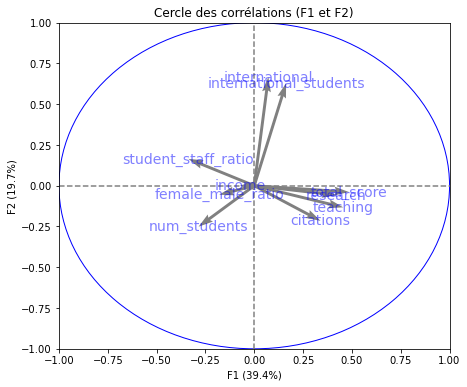

<Figure size 864x576 with 0 Axes>

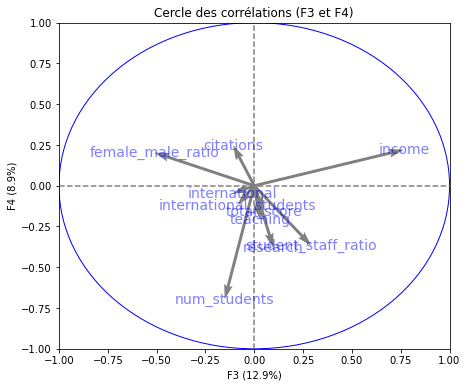

<Figure size 864x576 with 0 Axes>

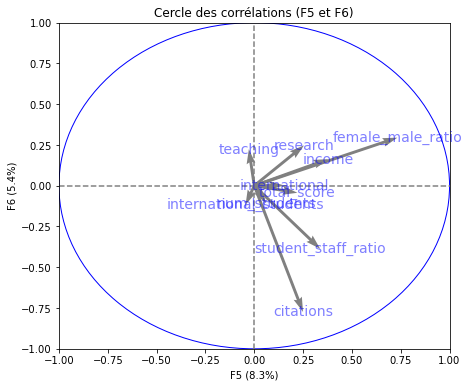

<Figure size 864x576 with 0 Axes>

In [19]:
# display_circles(pcs, n_comp, pca, [(0,1),(2,3),(4,5)], labels = np.array(features))
# display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
i = 0
for d1, d2 in [(0,1),(2,3),(4,5)]: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
    if d2 < n_comp:
        i +=1
        # initialisation de la figure
        fig, ax = plt.subplots(figsize=(7,6))

        # détermination des limites du graphique
        if pcs.shape[1] < 30 :
            xmin, xmax, ymin, ymax = -1, 1, -1, 1
        else :
            xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

        # affichage des flèches
        # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
        if pcs.shape[1] < 30 :
            plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
               pcs[d1,:], pcs[d2,:], 
               angles='xy', scale_units='xy', scale=1, color="grey")
            # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
        else:
            lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
            ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))

        # affichage des noms des variables 
        labels = np.array(features)
        label_rotation=0
        for i,(x, y) in enumerate(pcs[[d1,d2]].T):
            if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)

        # affichage du cercle
        circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
        plt.gca().add_artist(circle)

        # définition des limites du graphique
        plt.xlim(xmin, xmax)
        plt.ylim(ymin, ymax)

        # affichage des lignes horizontales et verticales
        plt.plot([-1, 1], [0, 0], color='grey', ls='--')
        plt.plot([0, 0], [-1, 1], color='grey', ls='--')

        # nom des axes, avec le pourcentage d'inertie expliqué
        plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
        plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

        plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
        plt.show(block=False)
        plt.savefig('img'+str(i))

In [12]:
# Transformation pour projection des individus
X_projected = pca.fit_transform(X_scaled)
pd.DataFrame(X_projected, index = df.index, columns = ["F"+str(i+1) for i in range (n_comp)])
f1 = pca.components_[0]
print('La composante F1')
f1

La composante F1


array([ 0.48510454,  0.42149616,  0.45564987,  0.33928486,  0.07233384,
       -0.07344465, -0.33702866, -0.28521429,  0.16305059, -0.17926586])

In [13]:
f2 = pca.components_[1]
print('La composante F2')
f2

La composante F2


array([-0.03883925, -0.05752422, -0.13270307, -0.21536718,  0.66546646,
        0.00095558,  0.16463334, -0.25132883,  0.628517  , -0.05512622])

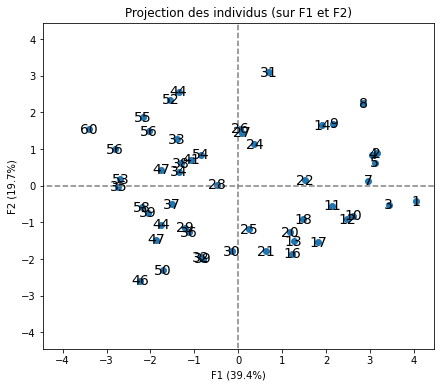

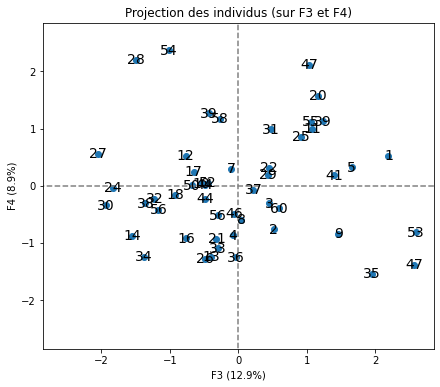

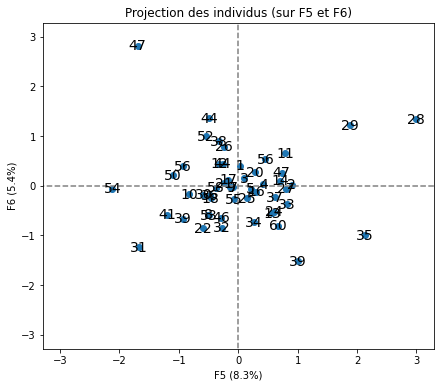

In [14]:
# Projection des individus
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca, [(0,1),(2,3),(4,5)], labels = np.array(names))

plt.show()